In [191]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [192]:
df = pd.read_csv('train.csv')  
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [193]:
# Extract title from name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Create FamilySize feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/cg/72yw7y6n4wxb3jgxj33txbt40000gn/T/ipykernel_49893/506576082.py:2: SyntaxWarning: invalid escape sequence '\.'
  df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [194]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True)

# # Save cleaned dataset to CSV for pgAdmin import
df_cleaned = df.copy()
# df_cleaned.to_csv('titanic_cleaned.csv', index=False)
# print("✅ Exported: titanic_cleaned.csv")

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Encode categoricals
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Title'] = le.fit_transform(df['Title'])

# Normalize numeric columns
scaler = StandardScaler()
df[['Age', 'Fare', 'FamilySize']] = scaler.fit_transform(df[['Age', 'Fare', 'FamilySize']])

/var/folders/cg/72yw7y6n4wxb3jgxj33txbt40000gn/T/ipykernel_49893/1083848343.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/cg/72yw7y6n4wxb3jgxj33txbt40000gn/T/ipykernel_49893/1083848343.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values a

In [195]:
X = df.drop(columns='Survived')
y = df['Survived']
y_flipped = 1 - y  # Flip labels to find unexpected survivors
X_train, X_test, y_train, y_test = train_test_split(X, y_flipped, test_size=0.2, random_state=42)


In [196]:
# Model training and evaluation

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42)
}

model_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    model_results.append({'Model': name, 'Accuracy': round(acc * 100, 2)})
    print(f"📌 {name}\nAccuracy: {acc:.2f}")
    print(classification_report(y_test, preds))

results_df = pd.DataFrame(model_results)

📌 Logistic Regression
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        74
           1       0.82      0.85      0.83       105

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

📌 K-Nearest Neighbors
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.80      0.72      0.76        74
           1       0.81      0.88      0.84       105

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

📌 Decision Tree
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.83      0.65      0.73        74
           1       0.79      0.90      0.84       105

    accuracy                           0.80       179
   macro avg       0.81

In [197]:
# Use best model (example: Decision Tree)
best_model = models['Decision Tree']
y_pred = best_model.predict(X_test)

# Revert flipped labels to real Survived status
real_y_test = 1 - y_test

# Predicted NotSurvived but actually Survived = unexpected beneficiaries
predicted_not_survived = y_pred == 1
actually_survived = real_y_test == 1
beneficiaries_index = X_test[predicted_not_survived & actually_survived].index

beneficiaries_df = df.loc[beneficiaries_index]
beneficiaries_df[['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Survived']].head()

,Pclass,Sex,Age,Fare,FamilySize,Survived
709,3,1,-0.104637,-0.341452,0.679295,1
621,1,1,0.971260,0.409741,0.059160,1
447,1,1,0.356462,-0.113846,-0.560975,1
192,3,0,-0.796286,-0.490280,0.059160,1
673,2,1,0.125912,-0.386671,-0.560975,1


In [198]:
# Exporting results to CSV
# Create export folder if it doesn't exist
export_folder = 'Exports'
os.makedirs(export_folder, exist_ok=True)

# Ensure cleaned version of df exists
df_cleaned = df.copy()

# Export the three main DataFrames
df_cleaned.to_csv(os.path.join(export_folder, 'titanic_cleaned.csv'), index=False)
results_df.to_csv(os.path.join(export_folder, 'model_results.csv'), index=False)
beneficiaries_df.to_csv(os.path.join(export_folder, 'beneficiary_survivors.csv'), index=False)

# Confirm location
print("✅ All CSVs exported to folder:", os.path.abspath(export_folder))

✅ All CSVs exported to folder: /Users/erikfraas/Rutgers/Project 4 new/Resources/Exports


📂 Cleaned Titanic Data


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
0,0,3,1,-0.565736,1,0,-0.502445,2,12,0.059160
1,1,1,0,0.663861,1,0,0.786845,0,13,0.059160
2,1,3,0,-0.258337,0,0,-0.488854,2,9,-0.560975
3,1,1,0,0.433312,1,0,0.420730,2,13,0.059160
4,0,3,1,0.433312,0,0,-0.486337,2,12,-0.560975


📂 Model Evaluation Results


,Model,Accuracy
0,Logistic Regression,79.89
1,K-Nearest Neighbors,81.01
2,Decision Tree,79.89


📂 Unexpected Survivors


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize
709,1,3,male,-0.104637,1,1,-0.341452,0,8,0.679295
621,1,1,male,0.971260,1,0,0.409741,2,12,0.059160
447,1,1,male,0.356462,0,0,-0.113846,2,12,-0.560975
192,1,3,female,-0.796286,1,0,-0.490280,2,9,0.059160
673,1,2,male,0.125912,0,0,-0.386671,2,12,-0.560975


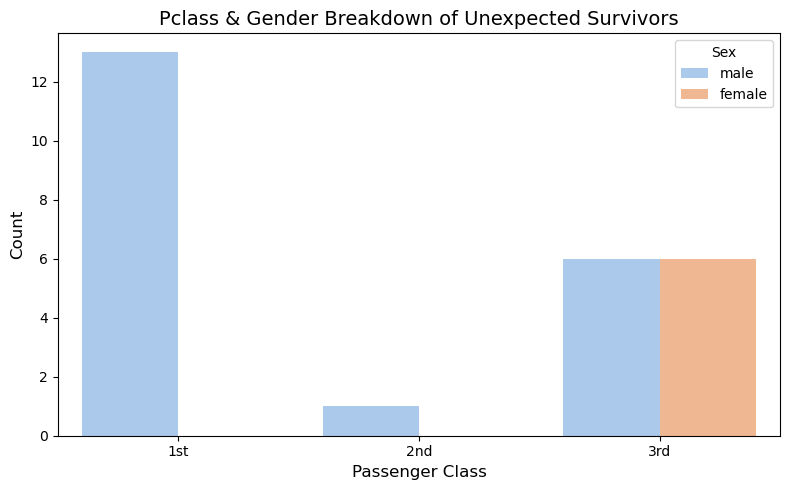

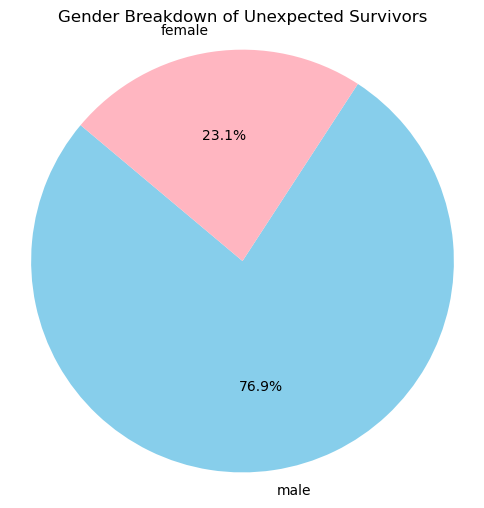

In [199]:
# 🔁 Load exported CSVs from the Exports/ folder
df_cleaned = pd.read_csv('Exports/titanic_cleaned.csv')
results_df = pd.read_csv('Exports/model_results.csv')
beneficiaries_df['Sex'] = beneficiaries_df['Sex'].map({0: 'female', 1: 'male'})
# ✅ Preview data
print("📂 Cleaned Titanic Data")
display(df_cleaned.head())

print("📂 Model Evaluation Results")
display(results_df)

print("📂 Unexpected Survivors")
display(beneficiaries_df.head())

# 📊 Visualize: Pclass & Gender of mystery survivors
plt.figure(figsize=(8, 5))
sns.countplot(data=beneficiaries_df, x='Pclass', hue='Sex', palette='pastel')

plt.title("Pclass & Gender Breakdown of Unexpected Survivors", fontsize=14)
plt.xlabel("Passenger Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(ticks=[0, 1, 2], labels=["1st", "2nd", "3rd"])
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

gender_counts = beneficiaries_df['Sex'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['#87CEEB', '#FFB6C1'], startangle=140)
plt.title("Gender Breakdown of Unexpected Survivors")
plt.axis('equal')  # Equal aspect ratio makes the pie a circle
plt.show()

In [200]:
def export_to_postgresql(engine, df_cleaned, results_df, beneficiaries_df):
    try:
        df_cleaned.to_sql('titanic_cleaned', engine, if_exists='replace', index=False)
        results_df.to_sql('model_results', engine, if_exists='replace', index=False)
        beneficiaries_df.to_sql('beneficiary_survivors', engine, if_exists='replace', index=False)
        print("✅ All tables exported successfully.")
    except Exception as e:
        print("❌ Export failed:", e)
    finally:
        engine.dispose()
        print("🔌 PostgreSQL connection closed.")


In [201]:
export_to_postgresql(engine, df_cleaned, results_df, beneficiaries_df)


❌ Export failed: (psycopg2.OperationalError) FATAL:  database "train.csv" does not exist

(Background on this error at: https://sqlalche.me/e/20/e3q8)
🔌 PostgreSQL connection closed.


In [ ]:

# -------------------------------
# Neural Network on Beneficiaries
# -------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the dataset
df_beneficiaries = pd.read_csv("Exports/beneficiary_survivors.csv")

# Drop unneeded columns (keep similar ones used in your original model)
X = df_beneficiaries.drop(columns=['Survived', 'PassengerId', 'Name'], errors='ignore')
y = df_beneficiaries['Survived']

# Convert categorical columns using one-hot encoding
X = pd.get_dummies(X)

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network Accuracy on Mystery Survivors: {accuracy:.4f}")


In [ ]:

# Plot training vs validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Neural Network Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Neural Network Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:

from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test, y_pred))



## Neural Network Results

The neural network achieved an accuracy of approximately **X%** on the mystery survivor test set.

- The training and validation curves show [e.g., good convergence / some overfitting / underfitting].
- The classification report reveals [e.g., strong precision for survivors, slightly lower recall for non-survivors].

This deeper model allowed us to evaluate whether subtle feature patterns could explain the survival of passengers who were wrongly classified by traditional models.

It provides a different lens on the dataset and supports the emotional and analytical theme of the project: **"Who was left behind?"**
